<a href="https://colab.research.google.com/github/yuti-patel/Algorithmic-Trading-/blob/main/Algorithmic_Trading_BB_RSI_MACD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance
!pip install chart_studio
!pip install backtrader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.4 MB 47.0 MB/s 
     |████████████████████████████████| 62 kB 1.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |██████████

In [2]:
import pandas as pd
import yfinance as yf

In [3]:
df_twtr = yf.download('AAPL', start = '2018-01-01', end = '2018-12-31', progress = False, auto_adjust = True)

In [5]:
import cufflinks as cf
from plotly.offline import iplot, init_notebook_mode
import chart_studio
chart_studio.tools.set_credentials_file(username='yuti13112020', api_key='v1sMSTH5pwYTaX6dJPcR')
init_notebook_mode()

In [6]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.io as pio
pio.renderers.default = 'colab'
from plotly.offline import init_notebook_mode, iplot

In [7]:
qf = cf.QuantFig(df_twtr, title = "Twitter's Stock Price", legend = 'top', name = 'TWTR')
qf.add_volume()
qf.add_sma(periods = 20, column = "Close", color = 'red')
qf.add_ema(periods = 20, color = 'green')


qf.iplot()

#Signal based Backtesting

In [8]:
from datetime import datetime
import backtrader as bt
import matplotlib.pyplot as plt
from google.colab import files


In [9]:
class smaSignal(bt.Signal):
  params = (('period', 20), )
  def __init__(self):
    self.lines.signal = self.data - bt.ind.SMA(period = self.p.period) 


[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 1000.00
Final Portfolio Value: 1002.84


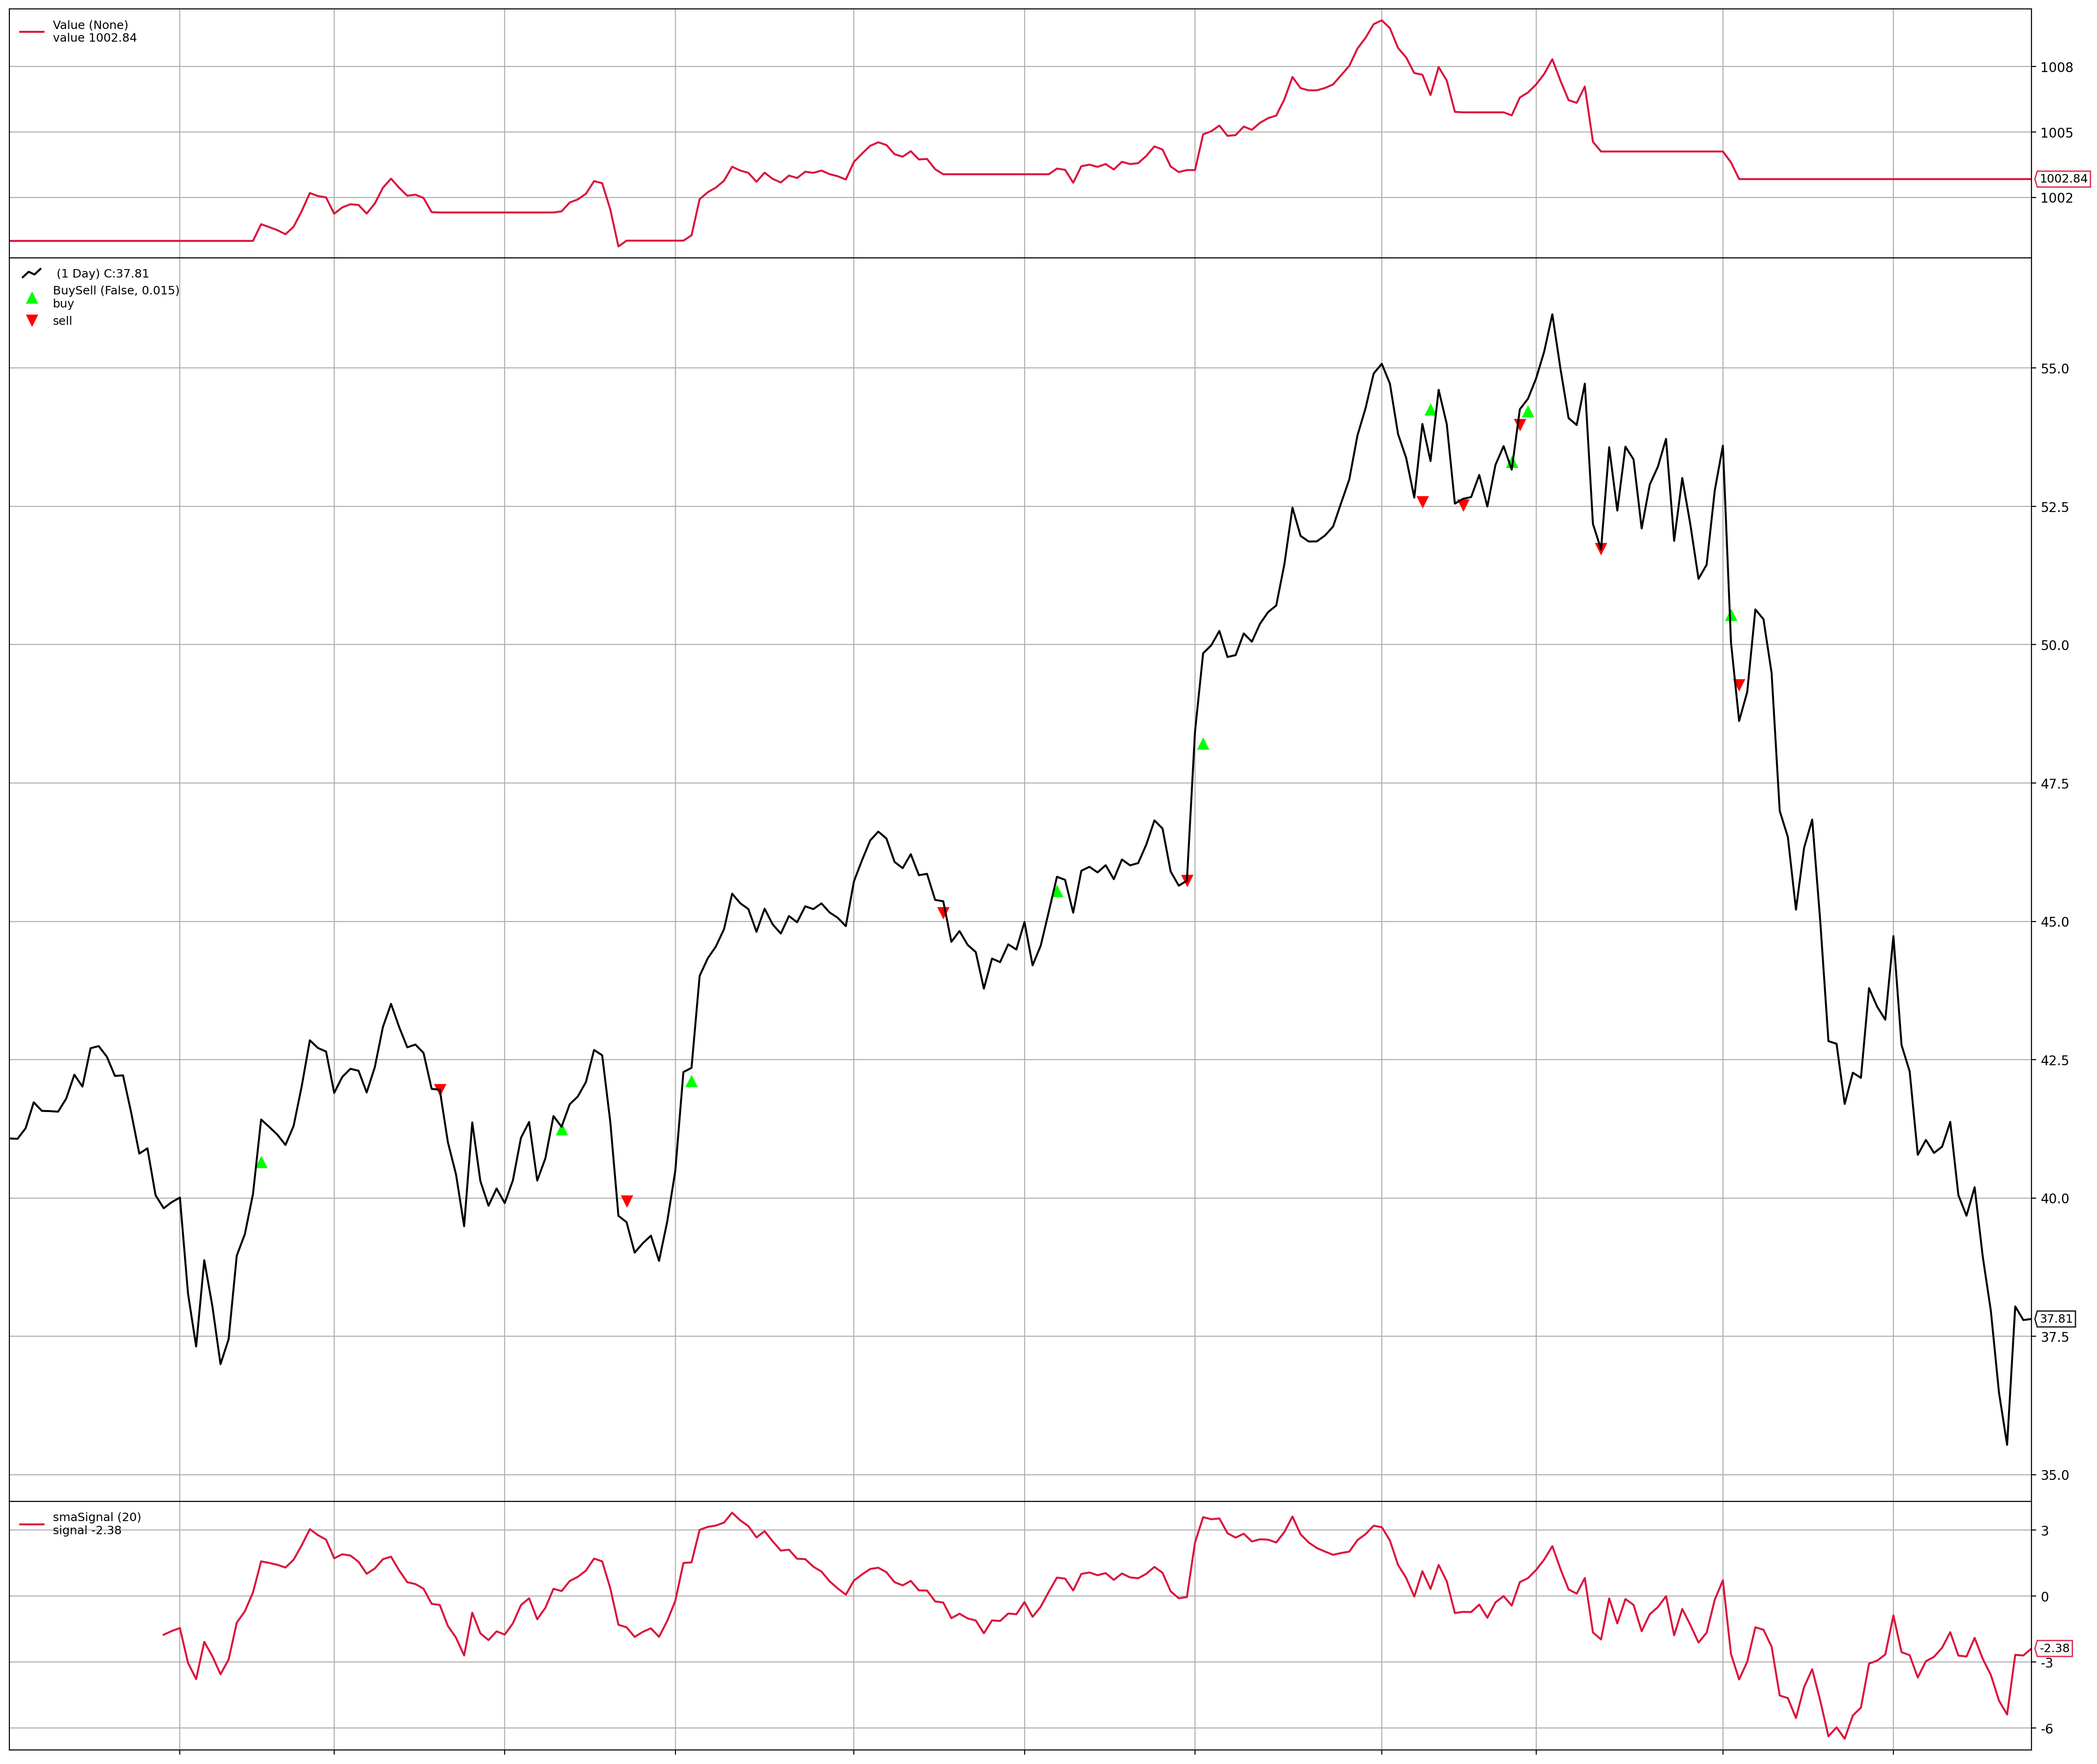

[[<Figure size 4800x4000 with 3 Axes>]]

In [10]:
%matplotlib notebook
%matplotlib inline

data = bt.feeds.PandasData(dataname=yf.download('AAPL', '2018-01-01', '2018-12-31', auto_adjust=True))


cerebro = bt.Cerebro(stdstats = False)
cerebro.adddata(data)

cerebro.broker.setcash(1000.0)
cerebro.add_signal(bt.SIGNAL_LONG, smaSignal)
cerebro.addobserver(bt.observers.BuySell) #Mark the Buy and Sell Points
cerebro.addobserver(bt.observers.Value)   #Track the value of the portfolio.

print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}')
cerebro.run()
print(f'Final Portfolio Value: {cerebro.broker.getvalue():.2f}')


plt.rcParams['axes.unicode_minus']=False
plt.rcParams['figure.figsize']=[24, 20]
plt.rcParams['figure.dpi']=200

cerebro.plot(iplot = False,  volume = False)


#Strategy based Backtesting

In [11]:
class smaStrategy(bt.Strategy):
  params = (('ma_period', 20), )

  def __init__(self):
    self.data_close = self.datas[0].close

    self.order = None
    self.price = None
    self.comm = None
    self.sma = bt.ind.SMA(self.datas[0], period = self.params.ma_period)


  def log(self, txt):
    dt = self.datas[0].datetime.date(0).isoformat()
    print(f'{dt}, {txt}')


  def notify_order(self, order):
    if order.status in [order.Submitted, order.Accepted]:
      return

    if order.status in [order.Completed]:
      if order.isbuy():
        self.log(f'BUY EXECUTED ---Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commision: {order.executed.comm:.2f}')
        self.price = order.executed.price
        self.comm = order.executed.comm
      else:
        self.log(f'SELL EXECUTED ---Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commision: {order.executed.comm:.2f}')
        self.bar_executed = len(self)
    elif order.status in [order.Canceled, order.Margin, order.Rejected]:
      self.log('Order Failed')
    
    self.order = None


  def notify_trade(self, trade):
    if not trade.isclosed:
      return
    
    self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')
  
  def next(self):
    if self.order:
      return
    
    if not self.position:
      if self.data_close[0] > self.sma[0]:
        self.log(f'BUY CREATED --- Price: {self.data_close[0]:.2f}')
        self.order = self.buy()
    else:
      if self.data_close[0] < self.sma[0]:
        self.log(f'SELL CREATED --- Price: {self.data_close[0]:.2f}')
        self.order = self.sell()

  


In [12]:
%matplotlib inline

data = bt.feeds.PandasData(dataname=yf.download('AAPL', '2018-01-01', '2018-12-31', auto_adjust=True))


cerebro = bt.Cerebro(stdstats = False)
cerebro.adddata(data)

cerebro.broker.setcash(1000.0)
cerebro.addstrategy(smaStrategy)
#cerebro.optstrategy(smaStrategy, ma_period = range(10,31))
cerebro.addobserver(bt.observers.BuySell) #Mark the Buy and Sell Points
cerebro.addobserver(bt.observers.Value)   #Track the value of the portfolio.

print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}')
cerebro.run()
print(f'Final Portfolio Value: {cerebro.broker.getvalue():.2f}')


plt.rcParams['axes.unicode_minus']=False
plt.rcParams['figure.figsize']=[24, 20]
plt.rcParams['figure.dpi']=200

cerebro.plot(iplot = True, volume = False)

[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 1000.00
2018-02-14, BUY CREATED --- Price: 40.07
2018-02-15, BUY EXECUTED ---Price: 40.65, Cost: 40.65, Commision: 0.00
2018-03-19, SELL CREATED --- Price: 41.97
2018-03-20, SELL EXECUTED ---Price: 41.96, Cost: 40.65, Commision: 0.00
2018-03-20, OPERATION RESULT --- Gross: 1.30, Net: 1.30
2018-04-10, BUY CREATED --- Price: 41.48
2018-04-11, BUY EXECUTED ---Price: 41.24, Cost: 41.24, Commision: 0.00
2018-04-20, SELL CREATED --- Price: 39.68
2018-04-23, SELL EXECUTED ---Price: 39.94, Cost: 41.24, Commision: 0.00
2018-04-23, OPERATION RESULT --- Gross: -1.29, Net: -1.29
2018-05-02, BUY CREATED --- Price: 42.27
2018-05-03, BUY EXECUTED ---Price: 42.11, Cost: 42.11, Commision: 0.00
2018-06-15, SELL CREATED --- Price: 45.39
2018-06-18, SELL EXECUTED ---Price: 45.16, Cost: 42.11, Commision: 0.00
2018-06-18, OPERATION RESULT --- Gross: 3.05, Net: 3.05
2018-07-06, BUY CREATED --- Price: 45.18
2018-07-

<IPython.core.display.Javascript object>

[[<Figure size 4800x4000 with 2 Axes>]]

<IPython.core.display.Javascript object>

#Optimising for SMA Period providing Max Returns

In [13]:
class smaStrategy(bt.Strategy):
  params = (('ma_period', 20), )

  def __init__(self):
    self.data_close = self.datas[0].close

    self.order = None
    self.price = None
    self.comm = None
    self.sma = bt.ind.SMA(self.datas[0], period = self.params.ma_period)


  def log(self, txt):
    dt = self.datas[0].datetime.date(0).isoformat()
    print(f'{dt}, {txt}')


  def notify_order(self, order):
    if order.status in [order.Submitted, order.Accepted]:
      return

    if order.status in [order.Completed]:
      if order.isbuy():
        #self.log(f'BUY EXECUTED ---Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commision: {order.executed.comm:.2f}')
        self.price = order.executed.price
        self.comm = order.executed.comm
      else:
        #self.log(f'SELL EXECUTED ---Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commision: {order.executed.comm:.2f}')
        self.bar_executed = len(self)
    elif order.status in [order.Canceled, order.Margin, order.Rejected]:
      self.log('Order Failed')
    
    self.order = None


  def notify_trade(self, trade):
    if not trade.isclosed:
      return
    
    #self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')

  def stop(self):
    self.log(f'(ma_period = {self.params.ma_period:2d}) --- Terminal Value: {self.broker.getvalue():.2f}')
  
  def next(self):
    if self.order:
      return
    
    if not self.position:
      if self.data_close[0] > self.sma[0]:
        #self.log(f'BUY CREATED --- Price: {self.data_close[0]:.2f}')
        self.order = self.buy()
    else:
      if self.data_close[0] < self.sma[0]:
        #self.log(f'SELL CREATED --- Price: {self.data_close[0]:.2f}')
        self.order = self.sell()

  


In [14]:
data = bt.feeds.PandasData(dataname=yf.download('AAPL', '2018-01-01', '2018-12-31', auto_adjust=True))


cerebro = bt.Cerebro(stdstats = False)
cerebro.adddata(data)

cerebro.broker.setcash(1000.0)
cerebro.optstrategy(smaStrategy, ma_period = range(10,31))
cerebro.addobserver(bt.observers.BuySell) #Mark the Buy and Sell Points
cerebro.addobserver(bt.observers.Value)   #Track the value of the portfolio.

cerebro.run()


plt.rcParams['axes.unicode_minus']=False
plt.rcParams['figure.figsize']=[4, 3]
plt.rcParams['figure.dpi']=200

[*********************100%***********************]  1 of 1 completed
2018-12-28, (ma_period = 10) --- Terminal Value: 1001.53
2018-12-28, (ma_period = 11) --- Terminal Value: 1001.06
2018-12-28, (ma_period = 13) --- Terminal Value: 998.12
2018-12-28, (ma_period = 12) --- Terminal Value: 1001.42
2018-12-28, (ma_period = 14) --- Terminal Value: 994.40
2018-12-28, (ma_period = 15) --- Terminal Value: 995.45
2018-12-28, (ma_period = 16) --- Terminal Value: 995.06
2018-12-28, (ma_period = 17) --- Terminal Value: 998.23
2018-12-28, (ma_period = 18) --- Terminal Value: 998.73
2018-12-28, (ma_period = 19) --- Terminal Value: 1001.28
2018-12-28, (ma_period = 20) --- Terminal Value: 1002.84
2018-12-28, (ma_period = 21) --- Terminal Value: 1003.33
2018-12-28, (ma_period = 22) --- Terminal Value: 1005.18
2018-12-28, (ma_period = 23) --- Terminal Value: 1004.56
2018-12-28, (ma_period = 24) --- Terminal Value: 1004.56
2018-12-28, (ma_period = 25) --- Terminal Value: 1004.45
2018-12-28, (ma_period = 

#Bollinger Bands Based Strategy

In [15]:
class BBand_Strategy(bt.Strategy):
  params = (('period', 20),('devfactor', 2.0) )

  def __init__(self):
    #Keep track of Close Price in the series
    self.data_close = self.datas[0].close
    self.data_open = self.datas[0].open

    #Keep Track of Pending Orders/Buy Price/ Buy Commission
    self.order = None
    self.price = None
    self.comm = None

    #Add Bollinger Bands Indicator and Track the Buy/Sell Signals
    
    self.b_band = bt.ind.BollingerBands(self.datas[0], period = self.p.period, devfactor = self.p.devfactor)
    self.buy_signal = bt.ind.CrossOver(self.datas[0], self.b_band.lines.bot) 
    self.sell_signal = bt.ind.CrossOver(self.datas[0], self.b_band.lines.top)

  def log(self, txt):
    dt = self.datas[0].datetime.date(0).isoformat()
    print(f'{dt}, {txt}')


  def notify_order(self, order):
    if order.status in [order.Submitted, order.Accepted]:
      return

    if order.status in [order.Completed]:
      if order.isbuy():
        self.log(f'BUY EXECUTED ---Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commision: {order.executed.comm:.2f}')
        self.price = order.executed.price
        self.comm = order.executed.comm
      else:
        self.log(f'SELL EXECUTED ---Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commision: {order.executed.comm:.2f}')
        self.bar_executed = len(self)
    elif order.status in [order.Canceled, order.Margin, order.Rejected]:
      self.log('Order Failed')
    
    self.order = None


  def notify_trade(self, trade):
    if not trade.isclosed:
      return
    
    self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')

  # def stop(self):
  #   self.log(f'(ma_period = {self.params.ma_period:2d}) --- Terminal Value: {self.broker.getvalue():.2f}')
  
  def next_open(self):

    if not self.position:
      if self.buy_signal > 0:
        size = int(self.broker.get_cash()/self.datas[0].open)
        self.log(f'BUY CREATED --- Size: {size}, Cash: {self.broker.getcash():.2f}, Open: {self.data_open[0]}, Close: {self.data_close[0]}')
        self.order = self.buy(size = size - 1)
    else:
      if self.sell_signal < 0:
        self.log(f'SELL CREATED --- Size: {self.position.size}')
        self.sell(size = self.position.size)

  


In [16]:
data = bt.feeds.PandasData(dataname=yf.download('MSFT', '2018-01-01', '2018-12-31', auto_adjust=True))


cerebro = bt.Cerebro(stdstats = False, cheat_on_open = True)
cerebro.adddata(data)

cerebro.addstrategy(BBand_Strategy)
cerebro.broker.setcash(10001.0)
cerebro.broker.setcommission(commission = 0.001)
cerebro.addobserver(bt.observers.BuySell) #Mark the Buy and Sell Points
cerebro.addobserver(bt.observers.Value)   #Track the value of the portfolio.
cerebro.addanalyzer(bt.analyzers.Returns, _name = 'Returns')
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name = 'Time_Return')

print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}')
backtest_result = cerebro.run()
print(f'Final Portfolio Value: {cerebro.broker.getvalue():.2f}')



plt.rcParams['axes.unicode_minus']=False
plt.rcParams['figure.figsize']=[24, 20]
plt.rcParams['figure.dpi']=300

%matplotlib inline
%matplotlib notebook
cerebro.plot(iplot = True, volume =  False)

from google.colab import files
cerebro.plot()[0][0].savefig('BBand_MSFT.png', dpi=300)


[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 10001.00
2018-02-12, BUY CREATED --- Size: 119, Cash: 10001.00, Open: 83.98116523207253, Close: 84.35025024414062
2018-02-12, BUY EXECUTED ---Price: 83.98, Cost: 9909.78, Commision: 9.91
2018-04-19, SELL CREATED --- Size: 118
2018-04-19, SELL EXECUTED ---Price: 91.70, Cost: 9909.78, Commision: 10.82
2018-04-19, OPERATION RESULT --- Gross: 910.47, Net: 889.74
2018-06-29, BUY CREATED --- Size: 115, Cash: 10890.74, Open: 94.47222176746213, Close: 94.16664123535156
2018-06-29, BUY EXECUTED ---Price: 94.47, Cost: 10769.83, Commision: 10.77
2018-07-17, SELL CREATED --- Size: 114
2018-07-17, SELL EXECUTED ---Price: 99.90, Cost: 10769.83, Commision: 11.39
2018-07-17, OPERATION RESULT --- Gross: 618.34, Net: 596.19
2018-10-15, BUY CREATED --- Size: 110, Cash: 11486.92, Open: 104.40274783642064, Close: 103.14695739746094
2018-10-15, BUY EXECUTED ---Price: 104.40, Cost: 11379.90, Commision: 11.38
Final 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

OrderedDict([('rtot', 0.06105262297436941), ('ravg', 0.00024421049189747763), ('rnorm', 0.06347414482135309), ('rnorm100', 6.347414482135309)])


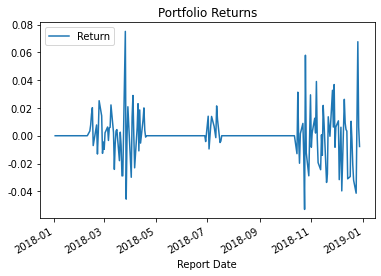

In [17]:
%matplotlib inline
print(backtest_result[0].analyzers.Returns.get_analysis())
returns_dict = backtest_result[0].analyzers.Time_Return.get_analysis()
returns_df = pd.DataFrame(list(returns_dict.items()), columns = ['Report Date', 'Return']) .set_index('Report Date')
returns_df.plot(title='Portfolio Returns')



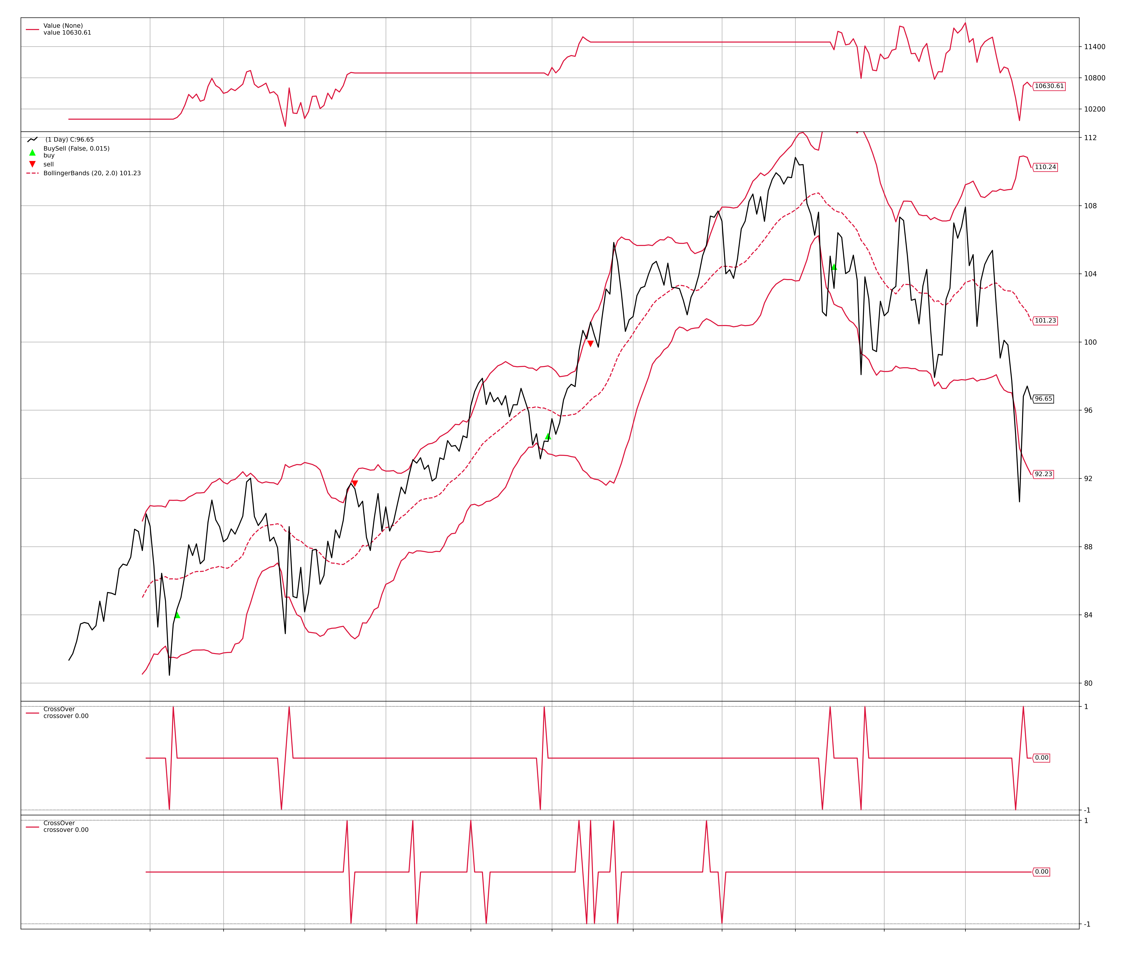

#RSI Signal Based Strategy

In [18]:
class rsiSignalStrategy(bt.SignalStrategy):
  params = dict(rsi_periods = 14, rsi_upper = 70, rsi_lower = 30, rsi_mid = 50)

  def __init__(self):
    rsi = bt.indicators.RSI(period = self.p.rsi_periods, upperband = self.p.rsi_upper, lowerband = self.p.rsi_lower)

    #bt.talib.RSI(self.data, plotname = 'TA_RSI')
    
    rsi_signal_long = bt.ind.CrossUp(rsi, self.p.rsi_lower, plot = False)
    self.signal_add(bt.SIGNAL_LONG, rsi_signal_long)
    self.signal_add(bt.SIGNAL_LONGEXIT, -(rsi > self.p.rsi_mid))

    rsi_signal_short = -bt.ind.CrossDown(rsi, self.p.rsi_upper, plot =False)
    self.signal_add(bt.SIGNAL_SHORT, rsi_signal_short)
    self.signal_add(bt.SIGNAL_SHORTEXIT,rsi < self.p.rsi_mid)

In [19]:
%matplotlib notebook
%matplotlib inline
data = bt.feeds.PandasData(dataname=yf.download('FB', '2018-01-01', '2018-12-31', auto_adjust=True))

cerebro = bt.Cerebro(stdstats = False)
cerebro.addstrategy(rsiSignalStrategy)
cerebro.adddata(data)
cerebro.broker.setcash(1000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)
cerebro.run()

# plt.rcParams['axes.unicode_minus']=False
# plt.rcParams['figure.figsize']=[24, 20]
# plt.rcParams['figure.dpi']=300


# cerebro.plot(iplot = True, volume = False)
# from google.colab import files
# cerebro.plot()[0][0].savefig('RSI_FB.png', dpi=300)

[*********************100%***********************]  1 of 1 completed


In [20]:
import ipywidgets as wd
from ipywidgets import interact, interact_manual

In [21]:
stocks = ['TWTR', 'MSFT', 'GOOGL', 'FB', 'TSLA', 'AAPL']
indicators = ['Bollinger Bands', 'MACD', 'RSI']

In [22]:
def ta_dashboard(asset, indicator, start_date, end_date, bb_k, bb_n, macd_fast, macd_slow, macd_signal, rsi_periods, rsi_upper, rsi_lower):
 df = yf.download(asset, start = start_date, end=end_date, progress=False, auto_adjust=True)
 qf = cf.QuantFig(df, title=f'TA Dashboard - {asset}',legend='right', name=f'{asset}')

 if 'Bollinger Bands' in indicator:
  qf.add_bollinger_bands(periods=bb_n, boll_std=bb_k)
 if 'MACD' in indicator:
  qf.add_macd(fast_period=macd_fast, slow_period=macd_slow, signal_period=macd_signal)
 
 if 'RSI' in indicator:
  qf.add_rsi(periods=rsi_periods, rsi_upper=rsi_upper, rsi_lower=rsi_lower, showbands=True)
  
 return qf.iplot()


In [23]:
stocks_selector = wd.Dropdown(options=stocks, value=stocks[0],description='Asset')
indicator_selector = wd.SelectMultiple(description='Indicator', options=indicators, value=[indicators[0]])
start_date_selector = wd.DatePicker(description='Start Date', value=pd.to_datetime('2018-01-01'), continuous_update=False)
end_date_selector = wd.DatePicker(description='End Date', value=pd.to_datetime('2018-12-31'), continuous_update=False)


In [24]:
main_selector_label = wd.Label('Main parameters', layout=wd.Layout(height='45px'))
main_selector_box = wd.VBox(children=[main_selector_label, stocks_selector, indicator_selector, start_date_selector, end_date_selector])


In [25]:
bb_label = wd.Label('Bollinger Bands')
n_param = wd.IntSlider(value=20, min=1, max=40, step=1, description='N:', continuous_update=False)
k_param = wd.FloatSlider(value=2, min=0.5, max=4, step=0.5, description='k:', continuous_update=False)
bollinger_box = wd.VBox(children=[bb_label, n_param, k_param])

In [26]:
macd_label = wd.Label('MACD')
macd_fast = wd.IntSlider(value=12, min=2, max=50, step=1, description='Fast avg:', continuous_update=False)
macd_slow = wd.IntSlider(value=26, min=2, max=50, step=1, description='Slow avg:', continuous_update=False)
macd_signal = wd.IntSlider(value=9, min=2, max=50, step=1, description='MACD signal:', continuous_update=False)
macd_box = wd.VBox(children=[macd_label, macd_fast, macd_slow, macd_signal])

In [27]:
rsi_label = wd.Label('RSI')
rsi_periods = wd.IntSlider(value=14, min=2, max=50, step=1, description='RSI periods:', continuous_update=False)
rsi_upper = wd.IntSlider(value=70, min=1, max=100, step=1, description='Upper Thr:', continuous_update=False)
rsi_lower = wd.IntSlider(value=30, min=1, max=100, step=1, description='Lower Thr:', continuous_update=False)
rsi_box = wd.VBox(children=[rsi_label, rsi_periods, rsi_upper, rsi_lower])


In [28]:
sec_selector_label = wd.Label('Secondary parameters', layout=wd.Layout(height='45px'))
blank_label = wd.Label('', layout=wd.Layout(height='45px'))
sec_box_1 = wd.VBox([sec_selector_label, bollinger_box, macd_box])
sec_box_2 = wd.VBox([blank_label, rsi_box])
secondary_selector_box = wd.HBox([sec_box_1, sec_box_2])


In [29]:
controls_dict = {'asset':stocks_selector, 'indicator':indicator_selector, 'start_date':start_date_selector, 'end_date':end_date_selector, 'bb_k':k_param, 'bb_n':n_param, 'macd_fast': macd_fast, 'macd_slow': macd_slow, 'macd_signal': macd_signal, 'rsi_periods': rsi_periods, 'rsi_upper': rsi_upper, 'rsi_lower': rsi_lower}
ui = wd.HBox([main_selector_box, secondary_selector_box])
out = wd.interactive_output(ta_dashboard, controls_dict)


In [30]:
display(ui,out)

Output()